In [1]:
%%capture
try:
    import xclim
except ModuleNotFoundError:
    ! pip install xclim

In [2]:
%matplotlib inline 
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from cartopy import config
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os 
import gcsfs 
from matplotlib import cm
import warnings 
import seaborn as sns
import yaml
from tqdm.auto import tqdm
import fsspec
from zarr.errors import GroupNotFoundError, ContainsGroupError

from xclim.indicators import cf
from xclim.indicators import icclim, atmos 

# from science_validation_manual import *
import dc6_functions
from scipy.stats import kstest
import geopandas as gpd
import dask
import dask.dataframe
import dask.array as da
import dask.distributed as dd
import rhg_compute_tools.kubernetes as rhgk
import rhg_compute_tools.utils as rhgu

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask_gateway/client.py:21: FutureWarning: format_bytes is deprecated and will be removed in a future release. Please use dask.utils.format_bytes instead.
  from distributed.utils import LoopRunner, format_bytes


In [3]:
import pprint

In [4]:
# import warnings
warnings.filterwarnings("ignore")

In [5]:
plot_dir = '/gcs/impactlab-data/climate/downscaling/paper/'

In [6]:
models_dict = dc6_functions.get_cmip6_models()
ensemble_members = dc6_functions.get_cmip6_ensemble_members()
grids = dc6_functions.get_cmip6_grids()
institutions = dc6_functions.get_cmip6_institutions()

In [7]:
EXTRA_PIP_SPEC = f'xclim=={xclim.__version__}'
EXTRA_PIP_SPEC

'xclim==0.34.0'

In [8]:
with open('../version_specs/dcmip6_all_paths.yaml', 'r') as f:
    all_paths = yaml.safe_load(f)

In [9]:
import importlib
importlib.reload(dc6_functions)

<module 'dc6_functions' from '/home/jovyan/downscaling/regional_diagnostics/dc6_functions.py'>

In [10]:
DC6_VERSION = 'v1.1'
SUMMARY_VERSION = 'v1.0'

DC6_PATT = (
    'gs://{CRS_SUPPORT_BUCKET}/internal_datasets/climate/CMIP6/gridded-climate-data/'
    'R_CIL_GDPCIR-{dc6_version}/{activity}/{institution_id}/{source_id}/{experiment_id}/'
    '{member_id}/{table_id}/{variable_id}/{dc6_version}.zarr'
)

ALT_DC6_PATT = (
    'gs://downscaled-288ec5ac/outputs/{activity}/{institution_id}/{source_id}/'
    '{experiment_id}/{member_id}/{table_id}/{variable_id}/{dc6_version}.zarr'
)

DC6_SUMMARY_PATT = (
    'gs://downscaled-288ec5ac/diagnostics/RELEASE-{dc6_version}/'
    '21-year-average-summaries/gridded/{activity}/{institution_id}/{source_id}/{experiment_id}/'
    '{member_id}/{table_id}/{variable_id}/{summary_version}.zarr'
)

DC6_REGION_PATT = (
    'gs://downscaled-288ec5ac/diagnostics/RELEASE-{dc6_version}/'
    '21-year-average-summaries/regional-cities-release/{region}/{activity}/'
    '{institution_id}/{source_id}/{experiment_id}/'
    '{member_id}/{table_id}/{variable_id}/{summary_version}.zarr'
)

POP_RASTER_WITH_REGION_ASSIGNMENTS = (
    'gs://downscaled-288ec5ac/diagnostics/rasters/'
    'gpw-v4-population-count-adjusted-to-2015-unwpp-country-totals-rev11_2020_30_sec/'
    'naturalearth_v5.0.0_adm0_and_adm1_assignments.parquet'
)

AGGREGATION_WEIGHTS_FILES = (
    'gs://downscaled-288ec5ac/diagnostics/aggregation_weights/popwt/{name}.parquet'
)

In [11]:
@rhgu.block_globals
def summarize_tasmax_ann(ds):
    tasmax_summaries = xr.Dataset({
        'number_of_days_with_tasmax_above_25C': atmos.tx_days_above(ds=ds, thresh='25 degC'),
        'number_of_days_with_tasmax_above_90F': atmos.tx_days_above(ds=ds, thresh='90 degF'),
        'number_of_days_with_tasmax_above_95F': atmos.tx_days_above(ds=ds, thresh='95 degF'),
        'annual_average_tasmax': cf.txmean(ds=ds),
    })

    return tasmax_summaries

In [12]:
@rhgu.block_globals
def summarize_tasmin_ann(ds):
    tasmin_summaries = xr.Dataset({
        'number_of_days_with_tasmin_above_20C': atmos.tn_days_above(ds=ds, thresh='20 degC'),
        'number_of_days_with_tasmin_below_0C': atmos.tn_days_below(ds=ds, thresh='0 degC'),
        'annual_average_tasmin': cf.tnmean(ds=ds),
    })

    return tasmin_summaries

In [13]:
@rhgu.block_globals
def summarize_pr_ann(ds):
    pr_summaries = xr.Dataset({
        'wetdays_above_1mm': atmos.wetdays(ds=ds, thresh='1 mm/day'),
        'wetdays_above_10mm': atmos.wetdays(ds=ds, thresh='10 mm/day'),
        'annual_total_precip': icclim.PRCPTOT(ds=ds),
    })

    return pr_summaries

In [14]:
@rhgu.block_globals
def summarize_tasmax_seas(ds):
    tasmax_summaries = xr.Dataset({
        'seasonal_average_tasmax': cf.txmean(ds=ds, freq='QS-DEC'),
    })

    return tasmax_summaries

In [15]:
@rhgu.block_globals
def summarize_tasmin_seas(ds):
    tasmin_summaries = xr.Dataset({
        'seasonal_average_tasmin': cf.tnmean(ds=ds, freq='QS-DEC'),
    })

    return tasmin_summaries

In [16]:
@rhgu.block_globals
def summarize_pr_seas(ds):
    pr_summaries = xr.Dataset({
        'seasonal_total_precip': icclim.PRCPTOT(ds=ds, freq='QS-DEC'),
    })

    return pr_summaries

In [17]:
ANNUAL_SUMMARY_FUNCS = {
    'tasmax': summarize_tasmax_ann,
    'tasmin': summarize_tasmin_ann,
    'pr': summarize_pr_ann,
}

SEASONAL_SUMMARY_FUNCS = {
    'tasmax': summarize_tasmax_seas,
    'tasmin': summarize_tasmin_seas,
    'pr': summarize_pr_seas,
}

In [18]:
@rhgu.block_globals(whitelist=[
    'DC6_VERSION',
    'DC6_PATT',
    'ALT_DC6_PATT',
    'SUMMARY_VERSION',
    'DC6_SUMMARY_PATT',
    'ANNUAL_SUMMARY_FUNCS',
    'SEASONAL_SUMMARY_FUNCS',
])
def compute_period_summaries(
    source_id,
    experiment_id,
    variable_id,
    return_results=False,
):

    fs = fsspec.filesystem(
        'gs',
        timeout=120,
        cache_timeout=120,
        requests_timeout=120,
        read_timeout=120,
        conn_timeout=120,
    )

    activity = ('CMIP' if experiment_id == 'historical' else 'ScenarioMIP')
    institution_id = dc6_functions.get_cmip6_institutions()[source_id]
    member_id = dc6_functions.get_cmip6_ensemble_members()[source_id]

    if (source_id == 'MPI-ESM1-2-HR') and (experiment_id == 'historical'):
        institution_id = 'MPI-M'

    if experiment_id == 'historical':
        periods = [1980, 2004]
    else:
        periods = [2030, 2050, 2089]

    fp = DC6_PATT.format(
        CRS_SUPPORT_BUCKET=os.environ['CRS_SUPPORT_BUCKET'],
        activity=activity,
        institution_id=institution_id,
        source_id=source_id,
        experiment_id=experiment_id,
        member_id=member_id,
        table_id='day',
        variable_id=variable_id,
        dc6_version=DC6_VERSION,
    )

    alt_fp = ALT_DC6_PATT.format(
        activity=activity,
        institution_id=institution_id,
        source_id=source_id,
        experiment_id=experiment_id,
        member_id=member_id,
        table_id='day',
        variable_id=variable_id,
        dc6_version=DC6_VERSION,
    )

    output_fp = DC6_SUMMARY_PATT.format(
        CRS_SUPPORT_BUCKET=os.environ['CRS_SUPPORT_BUCKET'],
        activity=activity,
        institution_id=institution_id,
        source_id=source_id,
        experiment_id=experiment_id,
        member_id=member_id,
        table_id='21yrroll',
        variable_id=variable_id,
        dc6_version=DC6_VERSION,
        summary_version=SUMMARY_VERSION,
    )

    if fs.isdir(output_fp):
        try:
            ds = xr.open_zarr(output_fp, consolidated=True, chunks=None).load()
            if return_results:
                return ds
            return
        except (FileNotFoundError, GroupNotFoundError, KeyError):
            try:
                fs.rm(output_fp)
            except (IOError, OSError):
                pass

            fs.invalidate_cache(path=None)

    if not fs.isdir(fp):
        assert fs.isdir(alt_fp), f"neither file found:\n\tonyx: {fp}\n\tdc6:  {alt_fp}"
        fp = alt_fp

    ds = xr.open_zarr(fp)

    annual_summary = ANNUAL_SUMMARY_FUNCS[variable_id](ds)
    seasonal_summary = SEASONAL_SUMMARY_FUNCS[variable_id](ds)

    summary_periods = xr.merge([
        xr.concat(
            [
                annual_summary.sel(time=slice(str(y-10), str(y+10))).mean(dim='time')
                for y in periods
            ],
            dim=pd.Index(periods, name='period'),
        ),
        xr.concat(
            [
                seasonal_summary.sel(time=slice(str(y-10), str(y+10))).groupby('time.season').mean(dim='time')
                for y in periods
            ],
            dim=pd.Index(periods, name='period'),
        ),
    ])

    summary_periods = summary_periods.compute(retries=3)
    summary_periods.attrs.update(ds.attrs)

    summary_periods.attrs.update({
        'frequency': '21yr_mean',
        'frequency_description': '21-year mean of annual summaries',
        'summary_update': pd.Timestamp.now(tz='US/Pacific').strftime('%c (%Z)'),
    })

    try:
        summary_periods.chunk().to_zarr(output_fp, consolidated=True)
    except ContainsGroupError:
        raise ContainsGroupError(f'directory not empty: {output_fp}')

    if return_results:
        return summary_periods

# Produce gridded summaries

In [ ]:
client, cluster = rhgk.get_standard_cluster(extra_pip_packages=EXTRA_PIP_SPEC)
cluster.scale(40)
cluster

In [19]:
with tqdm(list(dc6_functions.get_cmip6_models().items())) as pbar:
    for source_id, experiments in pbar:
        for experiment_id in experiments:
            for variable_id in ['tasmax', 'tasmin', 'pr']:
                pbar.set_postfix(
                    {'model': source_id, 'scen': experiment_id, 'variable': variable_id}
                )

                compute_period_summaries(source_id, experiment_id, variable_id)

  0%|          | 0/10 [00:00<?, ?it/s]

In [20]:
client.restart()
cluster.scale(0)
client.close()
cluster.close()

# Aggregate to regions

In [18]:
client, cluster = rhgk.get_big_cluster(extra_pip_packages=EXTRA_PIP_SPEC)
cluster.scale(12)
cluster

In [19]:
shapefile_sources = {
    'admin1': 'https://naciscdn.org/naturalearth/10m/cultural/ne_10m_admin_1_states_provinces.zip',
    'admin0': 'https://naciscdn.org/naturalearth/10m/cultural/ne_10m_admin_0_countries.zip'
}

In [20]:
admin1 = gpd.read_file(shapefile_sources['admin1'])

In [21]:
admin0 = gpd.read_file(shapefile_sources['admin0'])

In [22]:
city_spec = pd.DataFrame([
    {'city': 'Tokyo', 'lat': 35.681, 'lon': 139.767},
    {'city': 'Delhi', 'lat': 28.625, 'lon': 77.125},
    {'city': 'Shanghai', 'lat': 31.125, 'lon': 121.375},
    {'city': 'Sao Paulo', 'lat': -23.625, 'lon': -46.625},
    {'city': 'Mexico City', 'lat': 19.375, 'lon': -99.125},
    {'city': 'Cairo', 'lat': 30.125, 'lon': 31.125},
    {'city': 'Dhaka', 'lat': 23.875, 'lon': 90.375},
    {'city': 'New York', 'lat': 40.625, 'lon': -74.125},
    {'city': 'Buenos Aires', 'lat': -34.625, 'lon': -58.375},
    {'city': 'Istanbul', 'lat': 41.125, 'lon': 28.875},
    {'city': 'Lagos', 'lat': 6.510, 'lon': 3.370},
    {'city': 'Paris', 'lat': 48.875, 'lon': 2.375},
    {'city': 'Moscow', 'lat': 55.875, 'lon': 37.625},
    {'city': 'Miami', 'lat': 25.875, 'lon': -80.125},
    {'city': 'Mumbai', 'lat': 19.125, 'lon': 72.875},
    {'city': 'Manila', 'lat': 14.599, 'lon': 120.984},
    {'city': 'London', 'lat': 51.625, 'lon': -0.125},
]).set_index('city')

points = gpd.points_from_xy(city_spec.lon, city_spec.lat, crs='epsg:4326')
city_spec = gpd.GeoDataFrame(city_spec, geometry=points)
city_spec

,lat,lon,geometry
city,,,
Tokyo,35.681,139.767,POINT (139.76700 35.68100)
Delhi,28.625,77.125,POINT (77.12500 28.62500)
Shanghai,31.125,121.375,POINT (121.37500 31.12500)
Sao Paulo,-23.625,-46.625,POINT (-46.62500 -23.62500)
Mexico City,19.375,-99.125,POINT (-99.12500 19.37500)
Cairo,30.125,31.125,POINT (31.12500 30.12500)
Dhaka,23.875,90.375,POINT (90.37500 23.87500)
New York,40.625,-74.125,POINT (-74.12500 40.62500)
Buenos Aires,-34.625,-58.375,POINT (-58.37500 -34.62500)


In [23]:
city_spec['ADM0_A3'] = gpd.sjoin(city_spec, admin0, how='left')['ADM0_A3']
city_spec['adm1_code'] = gpd.sjoin(city_spec, admin1, how='left')['adm1_code']

In [24]:
city_spec

,lat,lon,geometry,ADM0_A3,adm1_code
city,,,,,
Tokyo,35.681,139.767,POINT (139.76700 35.68100),JPN,JPN-1860
Delhi,28.625,77.125,POINT (77.12500 28.62500),IND,IND-2428
Shanghai,31.125,121.375,POINT (121.37500 31.12500),CHN,CHN-1819
Sao Paulo,-23.625,-46.625,POINT (-46.62500 -23.62500),BRA,BRA-1311
Mexico City,19.375,-99.125,POINT (-99.12500 19.37500),MEX,MEX-2727
Cairo,30.125,31.125,POINT (31.12500 30.12500),EGY,EGY-1544
Dhaka,23.875,90.375,POINT (90.37500 23.87500),BGD,BGD-1806
New York,40.625,-74.125,POINT (-74.12500 40.62500),USA,USA-3559
Buenos Aires,-34.625,-58.375,POINT (-58.37500 -34.62500),ARG,ARG-5493


In [25]:
def get_pop_raster():
    pop_raster = dask.dataframe.read_parquet(POP_RASTER_WITH_REGION_ASSIGNMENTS)
    pop_raster = pop_raster[
        (pop_raster.population > 0)
        & (
            pop_raster.ADM0_A3.isin(city_spec.ADM0_A3)
            | pop_raster.adm1_code.isin(city_spec.adm1_code)
        )
    ].persist()

    dd.progress(pop_raster, notebook=False)

    return pop_raster

In [26]:
@rhgu.block_globals(whitelist=['AGGREGATION_WEIGHTS_FILES', 'city_spec'])
def get_aggregator(admin0, admin1):

    adm0_fp = AGGREGATION_WEIGHTS_FILES.format(
        name=f'reg-0p25-grid-aggregator/adm0_cities_popwt'
    )

    adm1_fp = AGGREGATION_WEIGHTS_FILES.format(
        name=f'reg-0p25-grid-aggregator/adm1_cities_popwt'
    )

    try:
        aggregator_adm0 = pd.read_parquet(adm0_fp)
        aggregator_adm1 = pd.read_parquet(adm1_fp)
        return aggregator_adm0, aggregator_adm1

    except (FileNotFoundError, IOError):
        pass

    pop_raster = get_pop_raster()

    res = 0.25
    binned_lat = ((pop_raster.y // res) + 0.5) * res
    binned_lon = ((pop_raster.x // res) + 0.5) * res

    this_pop_raster = pop_raster.assign(grid_lat=binned_lat, grid_lon=binned_lon)

    try:
        aggregator_adm0
    except NameError:

        aggregator_adm0 = (
            this_pop_raster
            .map_partitions(lambda df: df.groupby(['grid_lat', 'grid_lon', 'ADM0_A3']).population.sum())
            .compute()
            .groupby(level=['grid_lat', 'grid_lon', 'ADM0_A3'])
            .sum()
            .to_frame()
            .reset_index(drop=False)
        )

        aggregator_adm0 = aggregator_adm0[aggregator_adm0.population > 0]
        aggregator_adm0.to_parquet(adm0_fp)

    try:
        aggregator_adm1
    except NameError:

        aggregator_adm1 = (
            this_pop_raster[this_pop_raster.adm1_code.isin(city_spec.adm1_code.values)]
            .map_partitions(lambda df: df.groupby(['grid_lat', 'grid_lon', 'adm1_code']).population.sum())
            .compute()
            .groupby(level=['grid_lat', 'grid_lon', 'adm1_code'])
            .sum()
            .to_frame()
            .reset_index(drop=False)
        )

        aggregator_adm1 = aggregator_adm1[aggregator_adm1.population > 0]
        aggregator_adm1.to_parquet(adm1_fp)

    return aggregator_adm0, aggregator_adm1

In [27]:
shp_meta_cols = {
    'admin0': ['NAME', 'SOVEREIGNT'],
    'admin1': ['name', 'adm0_a3', 'admin'],
}

In [28]:
shapes = {
    'admin0': admin0,
    'admin1': admin1,
}

In [29]:
get_aggregator(admin0, admin1);

In [34]:
client.restart()
cluster.scale(0)
client.close()
cluster.close()

In [30]:
@rhgu.block_globals(whitelist=[
    'DC6_REGION_PATT',
    'DC6_VERSION',
    'SUMMARY_VERSION',
    'shp_meta_cols',
    'shapes',
    'shapefile_sources',
])
def aggregate(source_id, experiment_id, variable_id, aggregator_adm0, aggregator_adm1):

    fs = fsspec.filesystem(
        'gs',
        timeout=120,
        cache_timeout=120,
        requests_timeout=120,
        read_timeout=120,
        conn_timeout=120,
    )

    activity = ('CMIP' if experiment_id == 'historical' else 'ScenarioMIP')
    institution_id = dc6_functions.get_cmip6_institutions()[source_id]
    member_id = dc6_functions.get_cmip6_ensemble_members()[source_id]

    if (source_id == 'MPI-ESM1-2-HR') and (experiment_id == 'historical'):
        institution_id = 'MPI-M'

    adm0_out_fp = DC6_REGION_PATT.format(
        CRS_SUPPORT_BUCKET=os.environ['CRS_SUPPORT_BUCKET'],
        activity=activity,
        institution_id=institution_id,
        source_id=source_id,
        experiment_id=experiment_id,
        member_id=member_id,
        table_id='21yrroll',
        variable_id=variable_id,
        dc6_version=DC6_VERSION,
        summary_version=SUMMARY_VERSION,
        region='admin0',
    )

    adm1_out_fp = DC6_REGION_PATT.format(
        CRS_SUPPORT_BUCKET=os.environ['CRS_SUPPORT_BUCKET'],
        activity=activity,
        institution_id=institution_id,
        source_id=source_id,
        experiment_id=experiment_id,
        member_id=member_id,
        table_id='21yrroll',
        variable_id=variable_id,
        dc6_version=DC6_VERSION,
        summary_version=SUMMARY_VERSION,
        region='admin1',
    )

    if fs.exists(adm0_out_fp) and fs.exists(adm1_out_fp):
        return

    summary = compute_period_summaries(
        source_id,
        experiment_id,
        variable_id,
        return_results=True,
    )

    summary['lon'] = ((summary['lon'] + 180) % 360) - 180
    summary = summary.sortby('lon')

    for agg_kind, aggregator, agg_col, agg_fp in [
        ('admin0', aggregator_adm0, 'ADM0_A3', adm0_out_fp),
        ('admin1', aggregator_adm1, 'adm1_code', adm1_out_fp),
    ]:


        if fs.exists(agg_fp):
            continue

        summary_by_region = (
            (
                summary
                .sel(
                    lat=aggregator.grid_lat.to_xarray(),
                    lon=aggregator.grid_lon.to_xarray(),
                    method='nearest',
                    tolerance=1e-6,
                )
                * aggregator.population.to_xarray()
            )
            .groupby(aggregator[agg_col].to_xarray()).sum()
            / aggregator.groupby(agg_col).population.sum().to_xarray()
        )

        for v in summary_by_region.data_vars.keys():
            summary_by_region[v].attrs.update(summary[v].attrs)

        for col in shp_meta_cols[agg_kind]:
            summary_by_region.coords[col] = (
                shapes[agg_kind].set_index(agg_col)[col].to_xarray().astype(str)
            )
            summary_by_region.coords[col] = [str(v) for v in summary_by_region.coords[col].values]

        summary_by_region.attrs.update(summary.attrs)

        summary_by_region.attrs['regionagg_updated'] = (
            pd.Timestamp.now(tz='US/Pacific').strftime('%c (%Z)')
        )

        summary_by_region.attrs['regionagg_shape_name'] = agg_kind
        summary_by_region.attrs['regionagg_shape_source'] = shapefile_sources[agg_kind]
        summary_by_region.attrs['regionagg_weighting'] = 'population-weighted mean'

        summary_by_region.attrs['regionagg_weight_source'] = (
            'https://sedac.ciesin.columbia.edu/data/set/gpw-v4-population-density-'
            'adjusted-to-2015-unwpp-country-totals-rev11'
        )

        summary_by_region.attrs['regionagg_method'] = (
            '30 arcsecond population pixels are assigned (based on intersection) to '
            'polygons in the shapefile as well as to the coarse (0.25 degree) grid, '
            'then gridded summary statistics from the coarse resolution were weighted '
            'based on the fraction of regional population contained in the '
            'intersection of the region and each coarse grid cell, then averaged to '
            'produce the regional value.'
        )

        to_store = summary_by_region.copy()
        for var in to_store.variables:
            to_store[var].encoding.clear()

        to_store.chunk().to_zarr(agg_fp, consolidated=True)

In [31]:
aggregator_adm0, aggregator_adm1 = get_aggregator(
    admin0=admin0,
    admin1=admin1,
)

with tqdm(list(dc6_functions.get_cmip6_models().items())) as pbar:
    for source_id, experiments in pbar:

            for experiment_id in experiments:
                for variable_id in ['tasmax', 'tasmin', 'pr']:
                    pbar.set_postfix(
                        {'model': source_id, 'scen': experiment_id, 'variable': variable_id}
                    )

                    aggregate(
                        source_id,
                        experiment_id,
                        variable_id,
                        aggregator_adm0,
                        aggregator_adm1,
                    )

  0%|          | 0/25 [00:00<?, ?it/s]

In [22]:
source_id = 'GFDL-ESM4'
experiment_id = 'ssp245'
variable_id = 'tasmax'

tasmax_summary = compute_period_summaries(source_id, experiment_id, variable_id, return_results=True)

In [22]:
source_id = 'GFDL-ESM4'
experiment_id = 'ssp245'
variable_id = 'tasmin'

tasmin_summary = compute_period_summaries(source_id, experiment_id, variable_id, return_results=True)

In [23]:
source_id = 'GFDL-ESM4'
experiment_id = 'ssp245'
variable_id = 'pr'

pr_summary = compute_period_summaries(source_id, experiment_id, variable_id, return_results=True)

In [24]:
tasmax_summary

<xarray.Dataset>
Dimensions:                               (period: 3, lat: 720, lon: 1440, season: 4)
Coordinates:
  * lat                                   (lat) float64 -89.88 -89.62 ... 89.88
  * lon                                   (lon) float64 -179.9 -179.6 ... 179.9
  * period                                (period) int64 2030 2050 2089
  * season                                (season) object 'DJF' 'JJA' ... 'SON'
Data variables:
    annual_average_tasmax                 (period, lat, lon) float32 -43.22 ....
    number_of_days_with_tasmax_above_25C  (period, lat, lon) float64 0.0 ... 0.0
    number_of_days_with_tasmax_above_90F  (period, lat, lon) float64 0.0 ... 0.0
    number_of_days_with_tasmax_above_95F  (period, lat, lon) float64 0.0 ... 0.0
    seasonal_average_tasmax               (period, season, lat, lon) float32 ...
Attributes: (12/49)
    Conventions:                  CF-1.7 CMIP-6.0 UGRID-1.0
    activity_id:                  ScenarioMIP
    contact:                      climatesci@rhg.com
    creation_date:                2019-06-18T06:31:29Z
    data_specs_version:           01.00.27
    dc6_bias_correction_method:   Quantile Delta Method (QDM)
    ...                           ...
    summary_update:               Sun Mar 20 18:46:57 2022 (PDT)
    table_id:                     day
    tracking_id:                  hdl:21.14100/92fea15f-95eb-4e1d-903b-46c029...
    variable_id:                  tasmax
    variant_label:                r1i1p1f1
    version_id:                   v20180701

In [25]:
tasmin_summary

<xarray.Dataset>
Dimensions:                               (period: 3, lat: 720, lon: 1440, season: 4)
Coordinates:
  * lat                                   (lat) float64 -89.88 -89.62 ... 89.88
  * lon                                   (lon) float64 -179.9 -179.6 ... 179.9
  * period                                (period) int64 2030 2050 2089
  * season                                (season) object 'DJF' 'JJA' ... 'SON'
Data variables:
    annual_average_tasmin                 (period, lat, lon) float32 -47.16 ....
    number_of_days_with_tasmin_above_20C  (period, lat, lon) float64 0.0 ... 0.0
    number_of_days_with_tasmin_below_0C   (period, lat, lon) float64 365.0 .....
    seasonal_average_tasmin               (period, season, lat, lon) float32 ...
Attributes: (12/49)
    Conventions:                  CF-1.7 CMIP-6.0 UGRID-1.0
    activity_id:                  ScenarioMIP
    contact:                      climatesci@rhg.com
    creation_date:                2019-06-18T06:28:55Z
    data_specs_version:           01.00.27
    dc6_bias_correction_method:   Quantile Delta Method (QDM)
    ...                           ...
    summary_update:               Sun Mar 20 18:48:09 2022 (PDT)
    table_id:                     day
    tracking_id:                  hdl:21.14100/15982b1d-1080-41af-84f4-021873...
    variable_id:                  tasmin
    variant_label:                r1i1p1f1
    version_id:                   v20180701

In [26]:
pr_summary

<xarray.Dataset>
Dimensions:                (period: 3, lat: 720, lon: 1440, season: 4)
Coordinates:
  * lat                    (lat) float64 -89.88 -89.62 -89.38 ... 89.62 89.88
  * lon                    (lon) float64 -179.9 -179.6 -179.4 ... 179.6 179.9
  * period                 (period) int64 2030 2050 2089
  * season                 (season) object 'DJF' 'JJA' 'MAM' 'SON'
Data variables:
    annual_total_precip    (period, lat, lon) float64 64.95 74.39 ... 671.0
    seasonal_total_precip  (period, season, lat, lon) float64 10.92 ... 202.5
    wetdays_above_10mm     (period, lat, lon) float64 0.0 0.0 0.0 ... 7.905 13.0
    wetdays_above_1mm      (period, lat, lon) float64 44.62 47.9 ... 154.7 181.3
Attributes: (12/49)
    Conventions:                  CF-1.7 CMIP-6.0 UGRID-1.0
    activity_id:                  ScenarioMIP
    contact:                      climatesci@rhg.com
    creation_date:                2019-06-18T05:29:00Z
    data_specs_version:           01.00.27
    dc6_bias_correction_method:   Quantile Delta Method (QDM)
    ...                           ...
    summary_update:               Sun Mar 20 18:49:37 2022 (PDT)
    table_id:                     day
    tracking_id:                  hdl:21.14100/48767401-8960-4864-8738-e64640...
    variable_id:                  pr
    variant_label:                r1i1p1f1
    version_id:                   v20180701

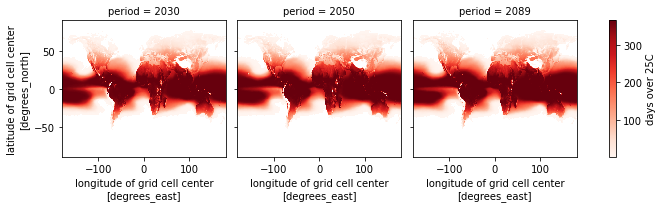

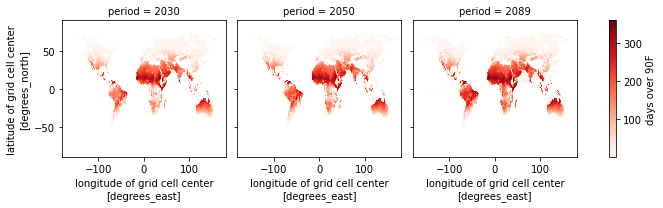

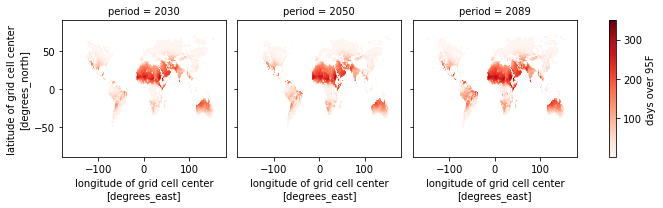

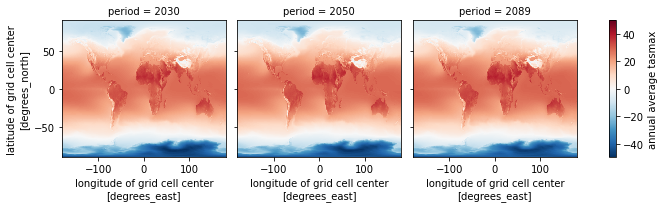

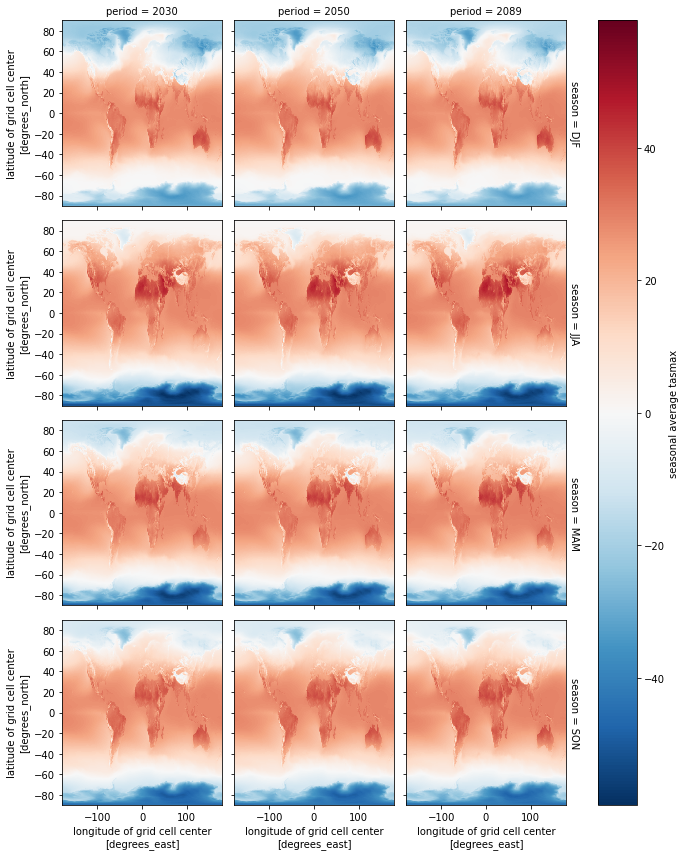

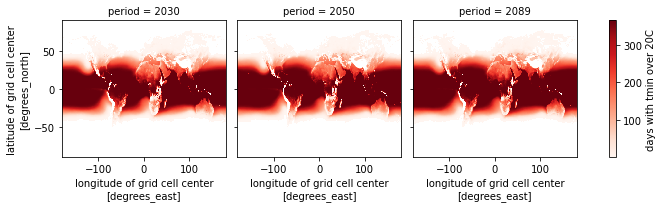

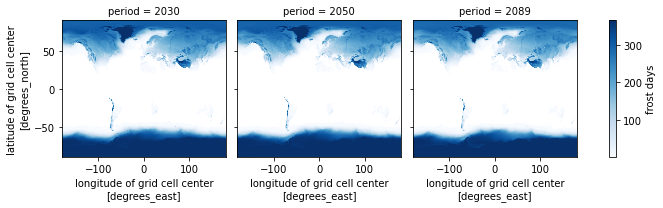

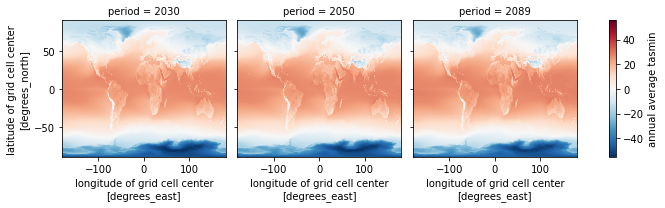

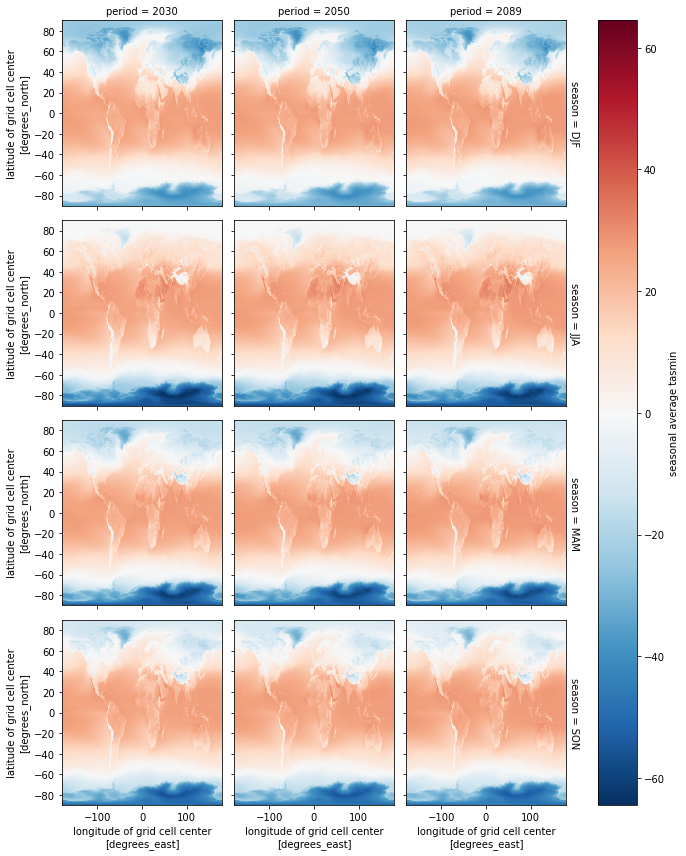

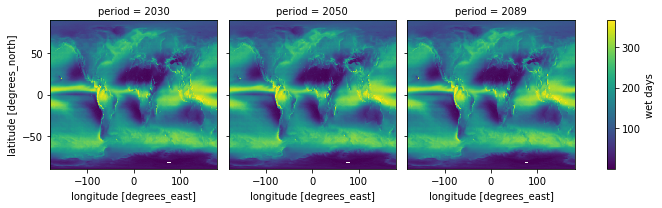

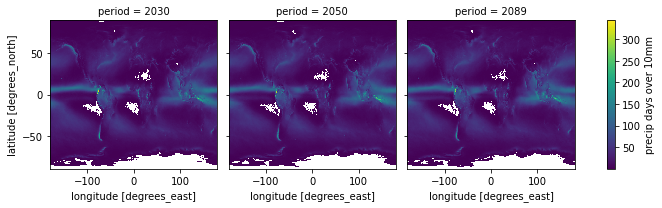

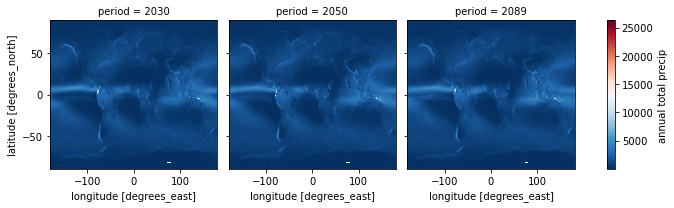

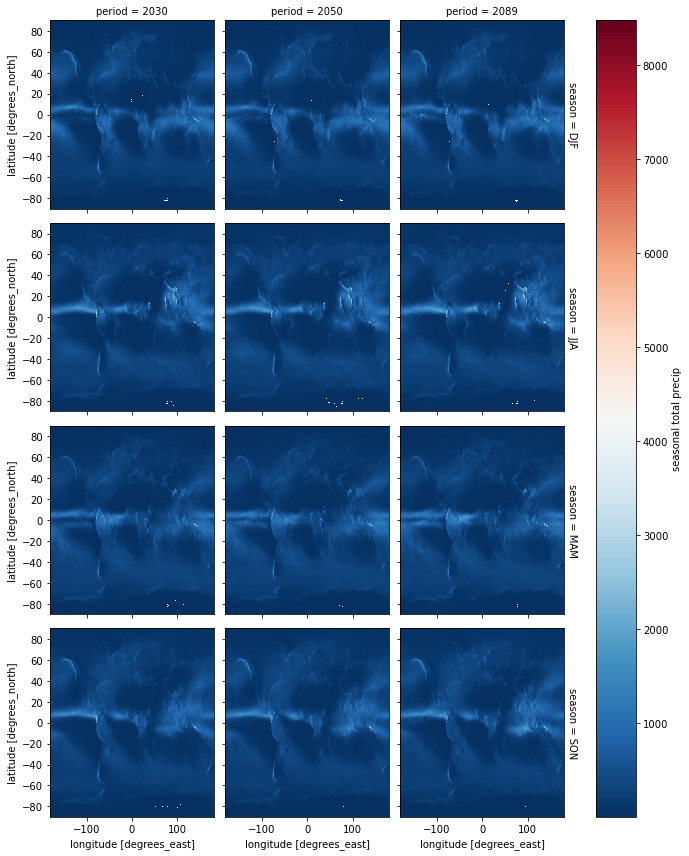

In [37]:
VARSPEC = {
    'tasmax': {
        'number_of_days_with_tasmax_above_25C': 'days over 25C',
        'number_of_days_with_tasmax_above_90F': 'days over 90F',
        'number_of_days_with_tasmax_above_95F': 'days over 95F',
        'annual_average_tasmax': 'annual average tasmax',
        'seasonal_average_tasmax': 'seasonal average tasmax',
    },
    'tasmin': {
        'number_of_days_with_tasmin_above_20C': 'days with tmin over 20C',
        'number_of_days_with_tasmin_below_0C': 'frost days',
        'annual_average_tasmin': 'annual average tasmin',
        'seasonal_average_tasmin': 'seasonal average tasmin',
    },
    'pr': {
        'wetdays_above_1mm': 'wet days',
        'wetdays_above_10mm': 'precip days over 10mm',
        'annual_total_precip': 'annual total precip',
        'seasonal_total_precip': 'seasonal total precip',
    },
}

for s, ds in [
    ('tasmax', tasmax_summary),
    ('tasmin', tasmin_summary),
    ('pr', pr_summary),
]:
    for v, l in VARSPEC[s].items():
        row_kwargs = ({'row': 'season'} if 'season' in ds[v].dims else {})
        if ('precip' in v) or ('wet' in v):
            cmap = 'viridis'
        elif (('average' in v) or ('total' in v)):
            cmap = 'RdBu_r'
        elif ('above' in v) and ('tas' in v):
            cmap = 'Reds'
        elif ('below' in v) and ('tas' in v):
            cmap = 'Blues'
        else:
            raise KeyError(f"{v} not understood")

        ds[v].where(ds[v]).assign_attrs(long_name=VARSPEC[s][v]).plot(
            col='period',
            cmap=cmap,
            **row_kwargs,
        )

In [ ]:
with tqdm(DELIVERY_MODELS) as pbar:
    

source_id = 'GFDL-ESM4'
experiment_id = 'ssp245'
variable_id = 'tasmax'

In [18]:
tasmax_summary

In [19]:
client.restart()
cluster.scale(0)
client.close()
cluster.close()

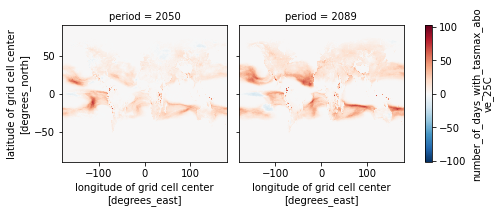

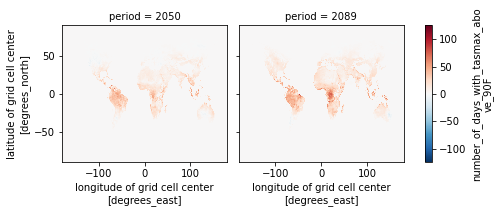

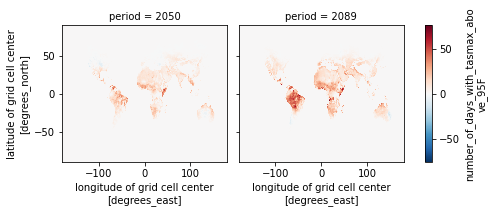

In [42]:
VARSPEC = {
    'number_of_days_with_tasmax_above_25C': 'days over 25C',
    'number_of_days_with_tasmax_above_90F': 'days over 90F',
    'number_of_days_with_tasmax_above_95F': 'days over 95F',
}
for v, l in VARSPEC.items():
    tasmax_periods[v].diff(dim='period').plot(
        col='period',
        cmap='RdBu_r',
    )

In [47]:
pop_raster = dask.dataframe.read_parquet('population_raster_with_adm0_and_adm1_assigned.parquet')

In [50]:
RES = 0.25
RES_STR = '0p25'

pop_raster[f'grid_{RES_STR}_lon'] = ((pop_raster['x'] // RES) + 0.5) * RES
pop_raster[f'grid_{RES_STR}_lat'] = ((pop_raster['y'] // RES) + 0.5) * RES

In [57]:
aggregator = (
    pop_raster
    .groupby(['grid_0p25_lon', 'grid_0p25_lat', 'ADM0_A3', 'adm1_code'])
    [['population']]
    .sum()
    .compute()
    .reset_index(drop=False)
)
aggregator

,grid_0p25_lon,grid_0p25_lat,ADM0_A3,adm1_code,population
0,-179.875,-19.125,FJI,FJI-2618,1.942195
1,-179.875,-18.875,FJI,FJI-2618,195.516098
2,-179.875,-16.875,FJI,FJI-2619,6792.275879
3,-179.875,-16.625,FJI,FJI-2619,3074.326660
4,-179.875,-16.375,FJI,FJI-2619,1309.494873
...,...,...,...,...,...
278177,179.875,69.125,RUS,RUS-2321,0.499236
278178,179.875,70.875,RUS,RUS-2321,1.740897
278179,179.875,71.125,RUS,RUS-2321,9.496108
278180,179.875,71.375,RUS,RUS-2321,8.909717


In [60]:
tasmax_by_country = (
    (
        tasmax_periods
        .sel(
            lat=aggregator.grid_0p25_lat.to_xarray(),
            lon=aggregator.grid_0p25_lon.to_xarray(),
        )
        * aggregator.population.to_xarray()
    )
    .groupby(aggregator.ADM0_A3.to_xarray()).sum()
    / aggregator.groupby('ADM0_A3').population.sum().to_xarray()
)

tasmax_by_country

<xarray.Dataset>
Dimensions:                               (period: 3, ADM0_A3: 242)
Coordinates:
  * period                                (period) int64 2030 2050 2089
  * ADM0_A3                               (ADM0_A3) object 'ABW' 'AFG' ... 'ZWE'
Data variables:
    number_of_days_with_tasmax_above_25C  (ADM0_A3, period) float64 365.0 ......
    number_of_days_with_tasmax_above_90F  (ADM0_A3, period) float64 0.0 ... 7...
    number_of_days_with_tasmax_above_95F  (ADM0_A3, period) float64 0.0 ... 2...

In [69]:
shapes = {
    'admin1': gpd.read_file('https://naciscdn.org/naturalearth/10m/cultural/ne_10m_admin_1_states_provinces.zip').set_index('adm1_code'),
    'admin0': gpd.read_file('https://naciscdn.org/naturalearth/10m/cultural/ne_10m_admin_0_countries.zip').set_index('ADM0_A3'),
}

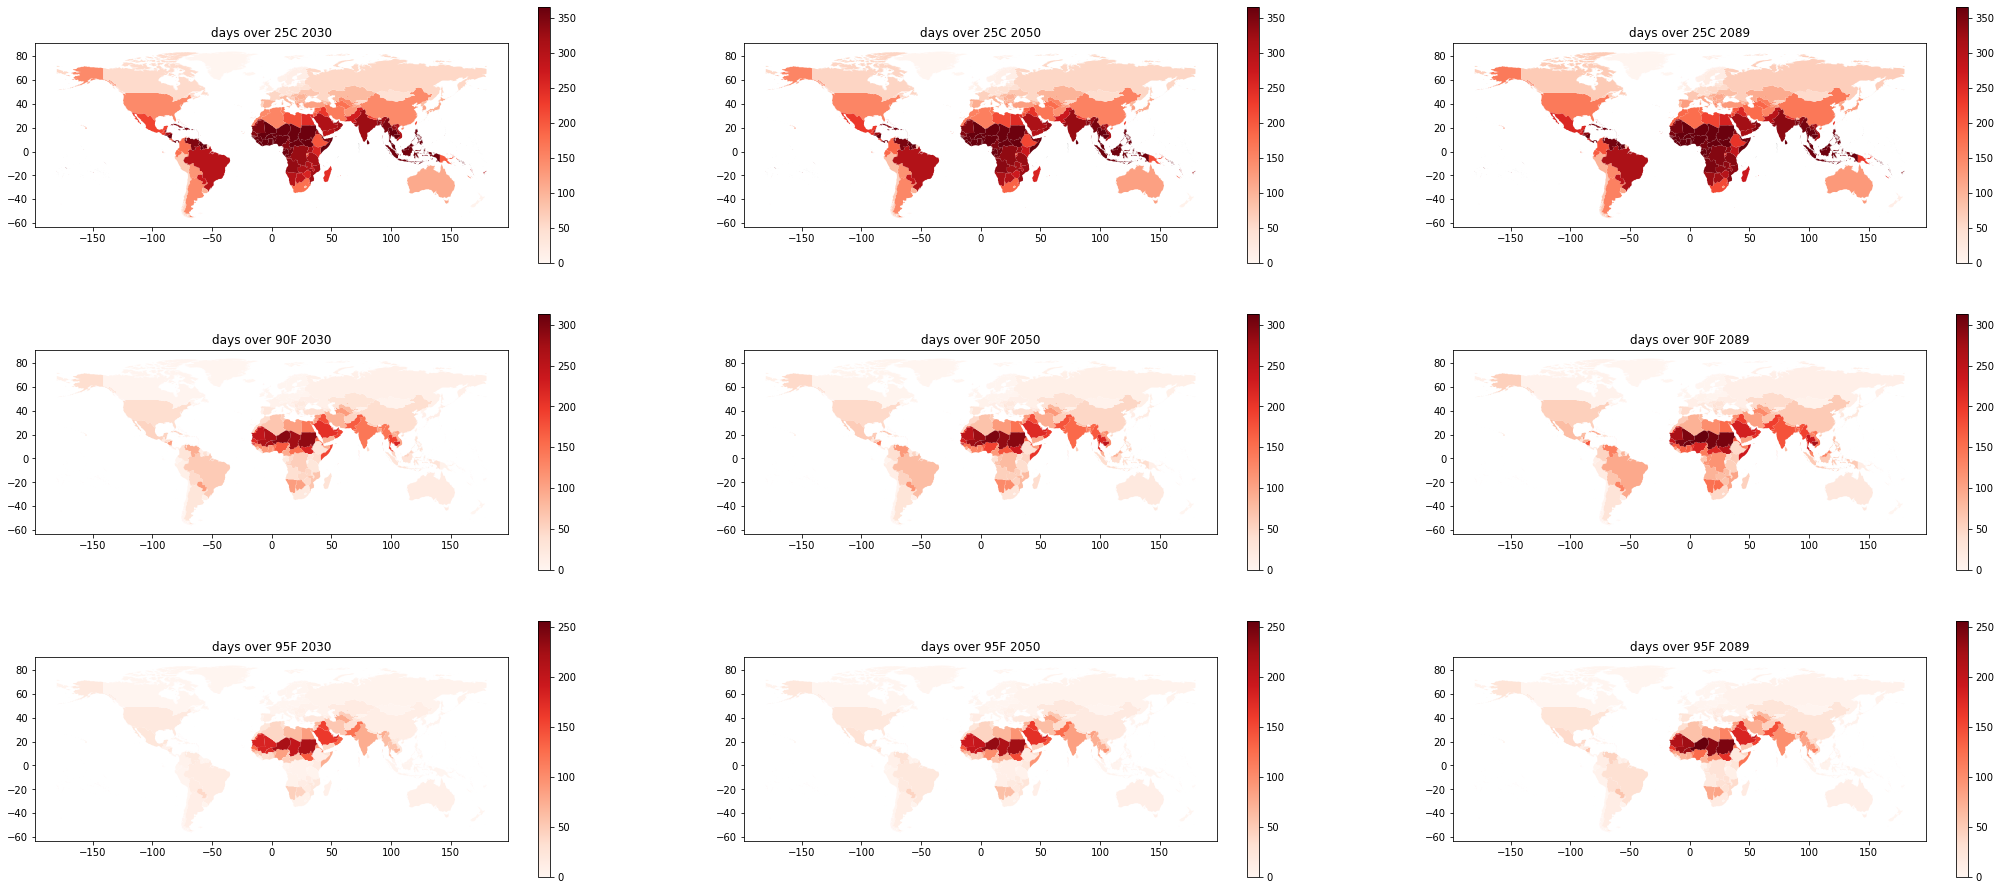

In [73]:
fig, axes = plt.subplots(3, 3, figsize=(36, 16))

for vi, (v, l) in enumerate(VARSPEC.items()):
    vmin = tasmax_by_country[v].min().item()
    vmax = tasmax_by_country[v].max().item()
    if vmin < 0:
        vmax = max(abs(vmin), abs(vmax))
        vmin = -vmax
    else:
        vmin, vmax = 0, vmax

    norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)

    for pi, p in enumerate(tasmax_by_country.period.values):
        ax = axes[vi, pi]
        shapes['admin0']['val'] = tasmax_by_country[v].sel(period=p).to_series()
        shapes['admin0'].plot('val', ax=ax, vmin=vmin, vmax=vmax, norm=norm, legend=True, cmap='Reds')

        ax.set_title(f'{l} {p}')

In [10]:
diag_type = 'annual'
data_type = 'downscaled'
variable = 'tasmax'
model = 'GFDL-ESM4'
ssp = 'ssp245'

filepath = dc6_functions.get_diagnostics_filepath(
    diag_type, data_type, institutions, ensemble_members, variable, model, ssp,
)

print(filepath)
u = dc6_functions.load_zarr(filepath)

gs://downscaled-288ec5ac/diagnostics/RELEASE-v1.1/annual-tasmax-diagnostics/ScenarioMIP/NOAA-GFDL/GFDL-ESM4/ssp245/r1i1p1f1/day/tasmax/v1.1.zarr


In [12]:
sliced = u.sel(lat=slice(23, 50), lon=slice(-115, -95)).compute()
sliced

<xarray.Dataset>
Dimensions:                 (year: 86, lat: 108, lon: 80)
Coordinates:
  * lat                     (lat) float64 23.12 23.38 23.62 ... 49.62 49.88
  * lon                     (lon) float64 -114.9 -114.6 -114.4 ... -95.38 -95.12
  * year                    (year) int64 2015 2016 2017 2018 ... 2098 2099 2100
Data variables:
    annual_average_tasmax   (year, lat, lon) float32 293.3 293.4 ... 285.9 285.0
    annual_count_above_95F  (year, lat, lon) int64 0 0 0 0 0 0 0 ... 0 0 0 0 0 0
Attributes: (12/47)
    Conventions:                  CF-1.7 CMIP-6.0 UGRID-1.0
    activity_id:                  ScenarioMIP
    contact:                      climatesci@rhg.com
    creation_date:                2019-06-18T06:31:29Z
    data_specs_version:           01.00.27
    dc6_bias_correction_method:   Quantile Delta Method (QDM)
    ...                           ...
    sub_experiment_id:            none
    table_id:                     day
    tracking_id:                  hdl:21.14100/92fea15f-95eb-4e1d-903b-46c029...
    variable_id:                  tasmax
    variant_label:                r1i1p1f1
    version_id:                   v20180701

In [13]:
sliced

<xarray.Dataset>
Dimensions:                 (year: 86, lat: 108, lon: 80)
Coordinates:
  * lat                     (lat) float64 23.12 23.38 23.62 ... 49.62 49.88
  * lon                     (lon) float64 -114.9 -114.6 -114.4 ... -95.38 -95.12
  * year                    (year) int64 2015 2016 2017 2018 ... 2098 2099 2100
Data variables:
    annual_average_tasmax   (year, lat, lon) float32 293.3 293.4 ... 285.9 285.0
    annual_count_above_95F  (year, lat, lon) int64 0 0 0 0 0 0 0 ... 0 0 0 0 0 0
Attributes: (12/47)
    Conventions:                  CF-1.7 CMIP-6.0 UGRID-1.0
    activity_id:                  ScenarioMIP
    contact:                      climatesci@rhg.com
    creation_date:                2019-06-18T06:31:29Z
    data_specs_version:           01.00.27
    dc6_bias_correction_method:   Quantile Delta Method (QDM)
    ...                           ...
    sub_experiment_id:            none
    table_id:                     day
    tracking_id:                  hdl:21.14100/92fea15f-95eb-4e1d-903b-46c029...
    variable_id:                  tasmax
    variant_label:                r1i1p1f1
    version_id:                   v20180701

downscaled data for one model 

Select 4 "moderate extremes" indicators: 

- "summer days" (SU, Number of summer days: Annual count of days when TX (daily maximum temperature) > 25oC) `atmos.tx_days_above`
- number of tropical nights (TR, Number of tropical nights: Annual count of days when TN (daily minimum temperature) > 20oC) `atmos.tn_days_above`
- number of wet days (per year) `atmos.wetdays`
- number of days with precip > 10mm `atmos.wetdays_prop`
- annual total precip `anuclim.P12_AnnualPrecip`

In [10]:
'''for model in models_dict.keys():
    print(model)'''

'for model in models_dict.keys():\n    print(model)'

In [12]:
city = 'Miami'

gcms_ks = {}
downscaled_ks = {}

etccdis = ['summer_days', 'tropical_nights', 'wet_days', 'wet_days_thresh']
models = ['GFDL-ESM4', 'GFDL-CM4', 'NorESM2-LM', 'NorESM2-MM', 'MIROC6']

diag_type = 'city'
data_type = 'downscaled'
# model = 'GFDL-ESM4'

for model in models_dict.keys():
    print(model)
    if model == 'MPI-ESM1-2-HR':
        pass
    else: 
        gcm_tests = 0
        ds_tests = 0

        for etccdi in etccdis:

            if etccdi == 'summer_days':
                variable = 'tasmax'
                var_name = 'tasmax'
            elif etccdi == 'tropical_nights':
                variable = 'tasmin'
                var_name = 'tasmin'
            else: 
                variable = 'precip'
                var_name = 'pr'

            ref = load_zarr(get_diagnostics_filepath(diag_type, 'reanalysis', institutions, ensemble_members, variable, model, 'historical')).sel(city=city)
            # print(get_diagnostics_filepath(diag_type, 'clean', variable, model, 'historical'))
            gcm = load_zarr(get_diagnostics_filepath(diag_type, 'clean', institutions, ensemble_members, variable, model, 'historical')).sel(city=city)
            # print(get_diagnostics_filepath(diag_type, 'downscaled', variable, model, 'historical'))
            downscaled = load_zarr(get_diagnostics_filepath(diag_type, 'downscaled', institutions, ensemble_members, variable, model, 'historical')).sel(city=city)

            ks_test_gcm = kstest(compute_etccdi(ref[var_name].sel(time=slice('1995', '2014')), etccdi), 
                                compute_etccdi(gcm[var_name].sel(time=slice('1995', '2014')), etccdi))

            ks_test_downscaled = kstest(compute_etccdi(ref[var_name].sel(time=slice('1995', '2014')), etccdi), 
                                compute_etccdi(downscaled[var_name].sel(time=slice('1995', '2014')), etccdi))
            if ks_test_gcm[1] < 0.05:
                gcm_tests += 1
            if ks_test_downscaled[1] < 0.05:
                ds_tests += 1
        gcms_ks[model] = gcm_tests
        downscaled_ks[model] = ds_tests

BCC-CSM2-MR
FGOALS-g3
ACCESS-ESM1-5
ACCESS-CM2
INM-CM4-8
INM-CM5-0
MIROC-ES2L
MIROC6
NorESM2-LM
NorESM2-MM
GFDL-ESM4
GFDL-CM4
NESM3
MPI-ESM1-2-HR
HadGEM3-GC31-LL
UKESM1-0-LL
MPI-ESM1-2-LR
CMCC-CM2-SR5
CMCC-ESM2
CanESM5
EC-Earth3
EC-Earth3-AerChem
EC-Earth3-CC
EC-Earth3-Veg
EC-Earth3-Veg-LR


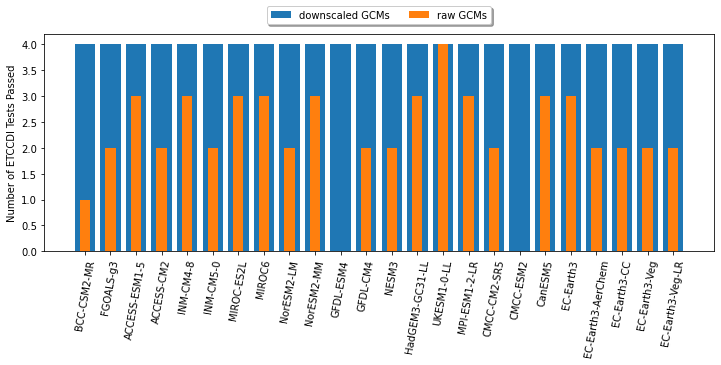

In [14]:
fig, axes = plt.subplots(1, 1, figsize=(12, 4))

axes.bar(*zip(*downscaled_ks.items()), width=0.8, linewidth=0.4, align='center', label='downscaled GCMs')
axes.bar(*zip(*gcms_ks.items()), width=0.4, linewidth=0.4, align='center', label='raw GCMs')
plt.xticks(rotation=80)
axes.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),
          ncol=2, fancybox=True, shadow=True)
axes.set_ylabel('Number of ETCCDI Tests Passed')

plt.savefig(os.path.join(plot_dir, 'miami_etccdi_indices_calibration.png'), 
            bbox_inches='tight', dpi=200)